In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim 
import normflows as nf
device='cuda'

In [ ]:
from tools.noise_scheduler import noise_scheduler
from tools.loss import noise_estimation_loss
from tools.score_net import score_model
from tools.sampling import ddpm_sampler

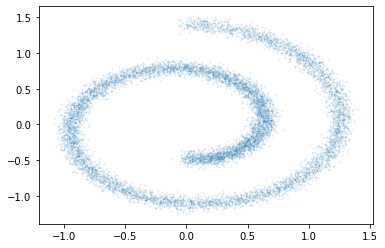

In [77]:
from sklearn.datasets import make_swiss_roll
def sample_batch(size, noise=0.5):
    x, _= make_swiss_roll(size, noise=noise)
    return x[:, [0, 2]] / 10.0
data = sample_batch(10**4)

# target = nf.distributions.TwoMoons()
# data = target.sample(100000)
# plt.scatter(data.numpy()[:,0], data.numpy()[:,1], s=1, alpha=0.1)

# import os
# obs_loc='/work/dante/scripts/VMEval/dataset/sbibm_tasks/two_moons/files/num_observation_2/'
# data=np.loadtxt(os.path.join(obs_loc,'reference_posterior_samples.csv'),delimiter=',',skiprows=1)
# #select data with x<0
# data=data[data[:,0]<0]
# #increase data number by adding small noise
# data_new=data+np.random.normal(0,0.01,data.shape)
# data=np.concatenate([data,data_new],axis=0)

plt.scatter(data[:,0], data[:,1], s=1, alpha=0.1)

In [78]:

ns=noise_scheduler(1e-5,1e-2,100,schedule='sigmoid')

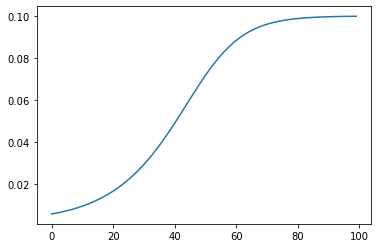

In [80]:
ns.plot_sigmas()

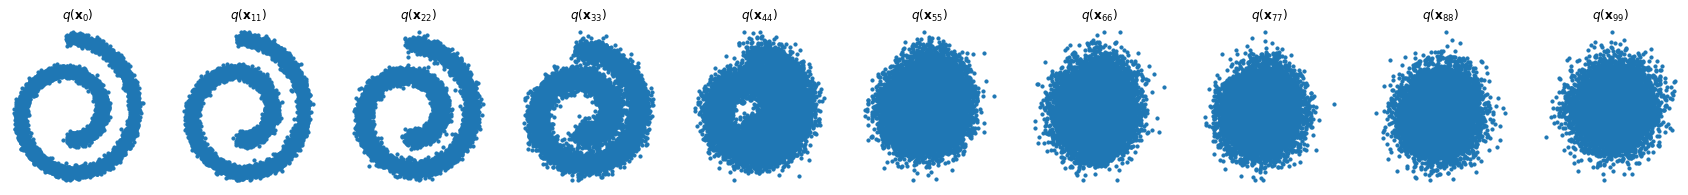

In [81]:
ns.visualize_noise(torch.tensor(data))

In [83]:

model = score_model(num_classes=100,x_dim=2).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [85]:
dataset=torch.tensor(data).float().to(device)
epochs = 1000
batch_size = 128
for epoch in range(epochs):

    permutation = torch.randperm(dataset.size()[0])
    for i in range(0, dataset.size()[0], batch_size):
        # Retrieve current batch
        indices = permutation[i:i+batch_size]
        batch_x = dataset[indices]

        t = torch.randint(0, ns.n_steps, size=(batch_x.shape[0] // 2 + 1,))
        t = torch.cat([t, ns.n_steps - t - 1], dim=0)[:batch_x.shape[0]].long().to(device)
        # Compute the loss.
        loss = noise_estimation_loss(model, batch_x, t,ns)

        optimizer.zero_grad()
        loss.backward()
        # Perform gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        optimizer.step()

    if (epoch % 100 == 0):
        print(loss.item())


0.6565882563591003
0.6256800293922424
0.6693724393844604
0.5997530221939087
0.8287950754165649
0.7123088836669922
0.602187991142273
0.6547769904136658
0.8405872583389282
0.40021172165870667


In [86]:

sampler=ddpm_sampler(model,ns.sigmas,ns.n_steps,device=device)

In [87]:
x_seq=sampler.loop_sample(dataset.shape)

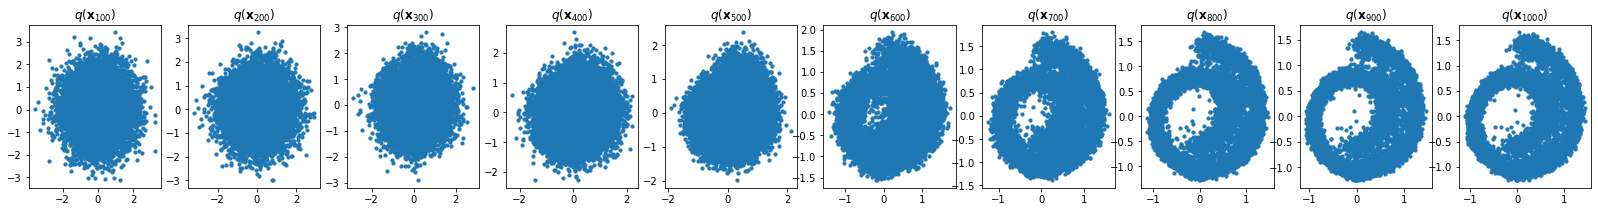

In [88]:
fig, axs = plt.subplots(1, 10, figsize=(28, 3))
for i in range(1, 11):
    cur_x = x_seq[i * 10].detach().cpu()
    axs[i-1].scatter(cur_x[:, 0], cur_x[:, 1], s=10);
    #axs[i-1].set_axis_off(); 
    axs[i-1].set_title('$q(\mathbf{x}_{'+str(i*100)+'})$')

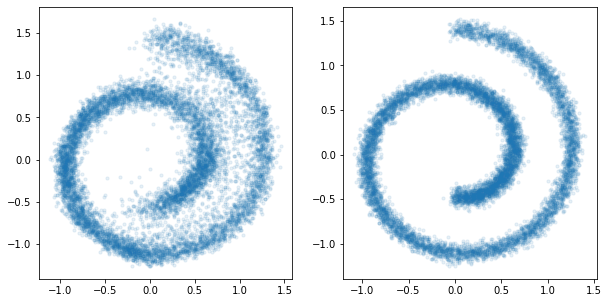

In [89]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(*x_seq[-1].detach().cpu().T, s=10, alpha=0.1)

plt.subplot(1, 2, 2)
plt.scatter(*data.T, s=10, alpha=0.1)


In [ ]:
sampler_20x=ddim_sampler(model, 1-ns.alphas, eta=0,tau=20, device='cuda', scheduling = 'uniform')
sampler_1x=ddim_sampler(model, 1-ns.alphas, eta=1,tau=1, device='cuda', scheduling = 'uniform')

In [ ]:
%%timeit
x_seq_ddpm=sampler_1x.loop_sample(data.shape)

51.2 ms ± 112 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%%timeit
x_seq_ddim=sampler_20x.loop_sample(data.shape)

2.81 ms ± 2.38 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
x_seq_ddpm=sampler_1x.loop_sample(data.shape)
x_seq_ddim=sampler_20x.loop_sample(data.shape)

Text(0.5, 1.0, 'Real Data')

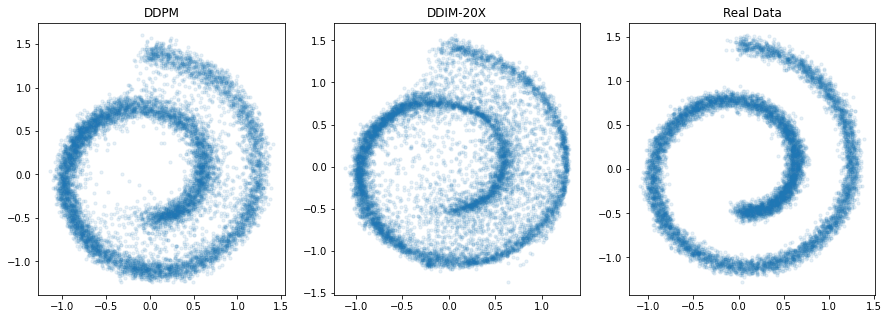

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.scatter(*x_seq_ddpm[-1].detach().cpu().T, s=10, alpha=0.1)
plt.title('DDPM')

plt.subplot(1, 3, 2)
plt.scatter(*x_seq_ddim[-1].detach().cpu().T, s=10, alpha=0.1)
plt.title('DDIM-20X')

plt.subplot(1, 3, 3)
plt.scatter(*data.T, s=10, alpha=0.1)
plt.title('Real Data')
